In [3]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")

set.seed(5366)

# Figure 5c: Which QTL type is most enriched for GWAS colocalization? 

## read supplemental table for GWAS colocalizations

In [4]:
gwas_coloc = fread("manuscript/tables/Table_SX_GWAS_Colocalizations.txt", data.table = F)
colnames(gwas_coloc)

head(gwas_coloc,2)

[1] "Tissue"                           "Trait_Description"               
 [3] "Trait_ID"                         "Cluster_ID"                      
 [5] "QTL_Combination"                  "Membership"                      
 [7] "Element_ID"                       "Condition"                       
 [9] "Element_Cond"                     "Element_Name"                    
[11] "Element_Chrom"                    "Element_Start"                   
[13] "Element_End"                      "Nsnps"                           
[15] "PP.H0"                            "PP.H1"                           
[17] "PP.H2"                            "PP.H3"                           
[19] "PP.H4"                            "Max_Hypothesis_PP"               
[21] "Likely_Colocalization_Hypothesis" "Top_SNP_ID"                      
[23] "Top_SNP_PP"                       "Proportion_Module_Colocalized"   
[25] "Beta.QTL"                         "SE.QTL"                          
[27] "Pvalue.QTL"                       "Beta.GWAS"                       
[29] "SE.GWAS"                          "Pvalue.GWAS"                     
[31] "99Credible_Set_Size"              "Colocalized"                     
[33] "Has_TFBS"                         "GWAS_Index"                      
[35] "GWAS_QTL_Combination_Collapse"    "Fetal_Unique_QTL"                
[37] "Fetal_Unique_GWAS_Locus"

,Tissue,Trait_Description,Trait_ID,Cluster_ID,QTL_Combination,Membership,Element_ID,Condition,Element_Cond,Element_Name,⋯,Beta.GWAS,SE.GWAS,Pvalue.GWAS,99Credible_Set_Size,Colocalized,Has_TFBS,GWAS_Index,GWAS_QTL_Combination_Collapse,Fetal_Unique_QTL,Fetal_Unique_GWAS_Locus
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<chr>
1,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_1059,caQTL-haQTL,Module,cvpc_chip_peak_9032,0,cvpc_chip_peak_9032_0,cvpc_chip_peak_9032,⋯,0.000275,0.001687,0.870348,121,FALSE,FALSE,No Colocalization,No Colocalization,TRUE,No Colocalization
2,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_1059,caQTL-haQTL,Module,cvpc_atac_peak_37717,0,cvpc_atac_peak_37717_0,cvpc_atac_peak_37717,⋯,0.000275,0.001687,0.870348,166,FALSE,FALSE,No Colocalization,No Colocalization,TRUE,No Colocalization


## number of QTL modules / singletons that colocalized

In [7]:
length(unique(gwas_coloc[gwas_coloc$Colocalized == T,]$Cluster_ID))

[1] 896

## prepare data for enrichment by annotating each cluster by whether they colocalized with GWAS or not

In [9]:
# Sort table by T/F for GWAS Colocalization and remove duplicates
# This outputs a list of all tested QTL clusters, annotated by whether they colocalized with GWAS or not
gwas_coloc2 = gwas_coloc %>% 
    select(Cluster_ID, QTL_Combination, Colocalized, Membership) %>% 
    arrange(desc(Colocalized)) %>% 
    filter(duplicated(Cluster_ID) == F)

head(gwas_coloc2,2)

,Cluster_ID,QTL_Combination,Colocalized,Membership
,<chr>,<chr>,<lgl>,<chr>
1,CVPC_10833,eQTL,TRUE,Singleton
2,CVPC_10854,haQTL,TRUE,Singleton


## how many clusters per QTL combination

In [10]:
table(gwas_coloc2$QTL_Combination)


           caQTL       caQTL-eQTL      caQTL-haQTL caQTL-haQTL-eQTL 
           31632             1917             1099              347 
            eQTL            haQTL       haQTL-eQTL 
           25849             9984              229 

## check that there are no duplicate QTL clusters

In [11]:
gwas_coloc2 %>% filter(duplicated(Cluster_ID))

Cluster_ID,QTL_Combination,Colocalized,Membership
<chr>,<chr>,<lgl>,<chr>


## annotate cluster

In [12]:
# annotate each cluster by:
# 1. whether the cluster was a module or a singleton 
# 2. their molecular phenotypes as well
gwas_coloc3 = gwas_coloc2 %>%
    mutate(QTL_Combination = paste(Membership, QTL_Combination))

unique(gwas_coloc3$QTL_Combination)


[1] "Singleton eQTL"          "Singleton haQTL"        
 [3] "Singleton caQTL"         "Module caQTL-eQTL"      
 [5] "Module haQTL-eQTL"       "Module caQTL-haQTL-eQTL"
 [7] "Module caQTL-haQTL"      "Module haQTL"           
 [9] "Module caQTL"            "Module eQTL"

## test enrichment using two-sided fisher's exact tests

In [20]:
# for each QTL combo
tests = as.data.frame(rbindlist(lapply(unique(gwas_coloc3$QTL_Combination), function(x)
{
    # annotation 1: Which cluster has the QTL combination label?
    this = gwas_coloc3 %>% mutate(in_cluster = ifelse(QTL_Combination == x, T, F))
    
    # annotation 2: Which cluster colocalized with at least one GWAS trait (already done)
    
    # fisher test
    test = fisher.test(table(this$in_cluster, this$Colocalized))
    f1 = length(unique(this[this$in_cluster == T & this$Colocalized == T,]$Cluster_ID)) / length(unique(this[this$in_cluster == T,]$Cluster_ID)) * 100
    f2 = length(unique(this[this$in_cluster == F & this$Colocalized == T,]$Cluster_ID)) / length(unique(this[this$in_cluster == F,]$Cluster_ID)) * 100
    
    # out
    data.frame(qtl_combo = x, 
               estimate = test$estimate, 
               pval = test$p.value, 
               ci1 = test$conf.int[1], 
               ci2 = test$conf.int[2], 
               in_frac = f1, 
               ot_frac = f2)
    
}))) %>% mutate(qval = p.adjust(pval, "BH")) %>% arrange(desc(estimate))

# sort by descending enrichment
tests$qtl_combo = factor(tests$qtl_combo, levels = tests$qtl_combo)

# enrichments that intersects 0 is not significant
tests$int_zero = log2(tests$ci1) * log2(tests$estimate)
tests$is_sig = ifelse(tests$qval <= 0.05 & tests$int_zero > 0, "Significant (FDR<0.05)", "Not Significant (FDR>0.05) ")


tests



qtl_combo,estimate,pval,ci1,ci2,in_frac,ot_frac,qval,int_zero,is_sig
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Module caQTL-haQTL-eQTL,7.6324365,2.523810e-16,5.0341094,11.1916907,8.6455331,1.224721,8.412700e-16,6.83698665,Significant (FDR<0.05)
Module haQTL,6.2694311,2.092493e-04,2.4419856,13.5233422,7.3684211,1.252783,2.324993e-04,3.41119970,Significant (FDR<0.05)
Module caQTL-eQTL,5.5848250,1.340945e-43,4.5269650,6.8420019,5.9989567,1.129592,1.340945e-42,5.40608360,Significant (FDR<0.05)
Module haQTL-eQTL,5.1643330,1.600360e-06,2.7647371,8.8991049,6.1135371,1.245270,2.000450e-06,3.47504693,Significant (FDR<0.05)
Module eQTL,4.1250990,1.098060e-14,2.9861998,5.5806081,4.8155738,1.211455,2.745149e-14,3.22674371,Significant (FDR<0.05)
Module caQTL,3.8217082,5.264005e-08,2.4367451,5.7431060,4.5620438,1.235303,7.520007e-08,2.48538330,Significant (FDR<0.05)
Module caQTL-haQTL,3.2987437,1.196645e-10,2.3555567,4.5130710,3.9126479,1.219303,1.994408e-10,2.12840620,Significant (FDR<0.05)
Singleton eQTL,0.8781323,7.228954e-02,0.7599207,1.0128434,1.1578820,1.316473,7.228954e-02,0.07426077,Not Significant (FDR>0.05)
Singleton caQTL,0.5478104,2.701801e-17,0.4727410,0.6334460,0.8653970,1.568559,1.350901e-16,0.93847389,Significant (FDR<0.05)


## plot results

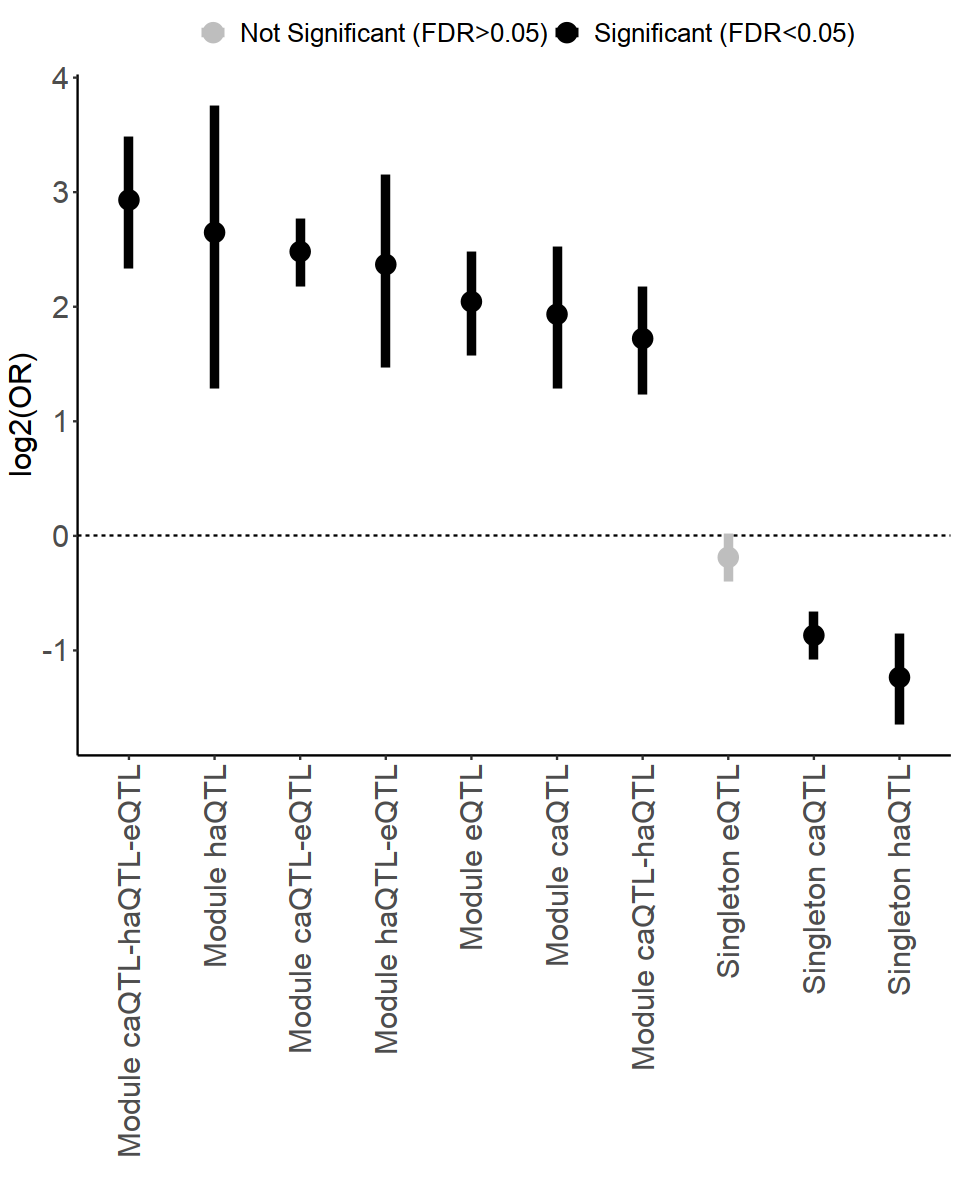

In [21]:
# plot
psize(w = 8, h = 10)
p3 = ggplot(tests, aes(x = qtl_combo, y = log2(estimate), color = is_sig)) + 
    geom_point(size = 5) + 
    geom_hline(yintercept = 0, linetype = "dashed") + 
    geom_segment(data = tests, aes(x = qtl_combo, xend = qtl_combo, y = log2(ci1), yend = log2(ci2)), size = 2) + 
    scale_color_manual(values = c("gray", "black"), name = "") + 
    jn_classic + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), legend.position = "top") + 
    xlab("") + ylab("log2(OR)") 
p3

## write source data

In [22]:
tests2 = tests %>% 
    dplyr::rename(QTL_Combination = qtl_combo,
                  Estimate = estimate,
                  Pvalue = pval,
                  CI1 = ci1,
                  CI2 = ci2,
                  Qvalue = qval,
                  Significant = is_sig) %>%
    select(-in_frac, -ot_frac, -int_zero)

fwrite(tests2, "manuscript/figures/SourceData.Figure5c.GWAS_QTL_Combo_Enrichment.txt", row.names = F, sep = "\t")

In [23]:
tests2

QTL_Combination,Estimate,Pvalue,CI1,CI2,Qvalue,Significant
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Module caQTL-haQTL-eQTL,7.6324365,2.523810e-16,5.0341094,11.1916907,8.412700e-16,Significant (FDR<0.05)
Module haQTL,6.2694311,2.092493e-04,2.4419856,13.5233422,2.324993e-04,Significant (FDR<0.05)
Module caQTL-eQTL,5.5848250,1.340945e-43,4.5269650,6.8420019,1.340945e-42,Significant (FDR<0.05)
Module haQTL-eQTL,5.1643330,1.600360e-06,2.7647371,8.8991049,2.000450e-06,Significant (FDR<0.05)
Module eQTL,4.1250990,1.098060e-14,2.9861998,5.5806081,2.745149e-14,Significant (FDR<0.05)
Module caQTL,3.8217082,5.264005e-08,2.4367451,5.7431060,7.520007e-08,Significant (FDR<0.05)
Module caQTL-haQTL,3.2987437,1.196645e-10,2.3555567,4.5130710,1.994408e-10,Significant (FDR<0.05)
Singleton eQTL,0.8781323,7.228954e-02,0.7599207,1.0128434,7.228954e-02,Not Significant (FDR>0.05)
Singleton caQTL,0.5478104,2.701801e-17,0.4727410,0.6334460,1.350901e-16,Significant (FDR<0.05)
